In [1]:
from example.pytorch_neat.main import run

In [2]:
# run()

In [3]:
from agent.base import Agent

import gym
import gym_gvgai

import matplotlib.pyplot as plt

# gym_gvgai.dir

# %matplotlib inline
# import gym
# import gym_gvgai
# import matplotlib.pyplot as plt
# from IPython import display
# def show_state(env, step=0, name="", info=""):
#     plt.figure(10)
#     plt.clf()
#     plt.imshow(env.render(mode="rgb_array"))
#     plt.title("{} | Step: {} {}".format(name, step, info))
#     plt.axis('off')
#     display.clear_output(wait=True)
#     display.display(plt.gcf())

In [4]:
import numpy as np
from agent.base import simulate
from generator.levels.base import _initialize
from generator.levels.base import Generator

In [5]:
gym_gvgai.dir

'/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/GVGAI_GYM/gym_gvgai'

In [7]:
import os
# sorted(os.listdir(os.path.join(gym_gvgai.dir, 'envs/games/zelda_v0/levels')))

In [8]:
# for f in sorted(os.listdir(os.path.join(gym_gvgai.dir, 'envs/games/zelda_v0/levels'))):
#     os.remove(os.path.join(gym_gvgai.dir, f'envs/games/zelda_v0/levels/{f}'))

# os.rmdir(os.path.join(gym_gvgai.dir, 'envs/games/zelda_v0/levels'))

In [9]:
from generator.env_gen_wrapper import GridGame

In [10]:
from agent.base import simulate

In [11]:
import numpy as np

In [12]:
from agent.NNagent import NNagent

In [14]:
popLim = 2
population = [None]*popLim

for i in range(len(population)):
    population[i] = NNagent(GridGame(game='zelda', 
                                     play_length=250, 
                                     path=gym_gvgai.dir + '/envs/games/zelda_v0/', 
                                     lvl_name='zelda_lvl0.txt', 
                                     mechanics=['1', '2', '3', '+', 'g', 'w'], # monster, key, door, wall
                                  )
                         )

Connecting to host 127.0.0.1 at port 60537 ...
Client connected to server [OK]
Connecting to host 127.0.0.1 at port 45827 ...
Client connected to server [OK]


In [16]:
from multiprocessing import Pool

In [15]:
def determine_fitness(x):
    return x.fitness()

In [17]:
p = Pool(5)
print(p.map(determine_fitness, population))

TypeError: cannot serialize '_io.TextIOWrapper' object

In [13]:
# population[0].update()

- kill oldest.   

- Write mutate wrapper that lives at top of Pair that will create a new Pair obj  
- Copy the Agent, mutate the env.  

- Flip fiber bits in the Tensor NN input.  

----  
- Interestingly, POET has a default of `max_children=8` for each reporduce step. 

In [ ]:
population

In [14]:
for epochs in range(2):
    for i in range(len(population)):
        population[i].fitness()    
    
    for i in range(len(population)):
        for _ in range(3):
            population.append(population[i].mutate(0.7))
        
    print(f"parents + children = {len(population)} members")
    population = sorted(population, key=lambda x: x.env.id, reverse=True)[:popLim] 
    # sort by id, kill Pairs with smallest IDs. 
    print(f"new generation has {len(population)} members")
    


running agent
evaluating agent
lived until end of env: +1.0
1
removing +?
new mutation 2
spawning w?
potential location (8, 2)
potential location (1, 1)
potential location (5, 6)
Connecting to host 127.0.0.1 at port 57199 ...
Client connected to server [OK]
Connecting to host 127.0.0.1 at port 42333 ...
Client connected to server [OK]
2
spawning 1?
potential location (6, 11)
Connecting to host 127.0.0.1 at port 36399 ...
Client connected to server [OK]
parents + children = 4 members
new generation has 4 members
running agent
evaluating agent
running agent
evaluating agent
lived until end of env: +1.0
running agent
evaluating agent
lived until end of env: +1.0
running agent
evaluating agent
lived until end of env: +1.0
Connecting to host 127.0.0.1 at port 56475 ...
Client connected to server [OK]
3
moving A?
from (1, 1)
potential location (4, 9)
Connecting to host 127.0.0.1 at port 49349 ...
Client connected to server [OK]
2
spawning 2?
potential location (1, 9)
Connecting to host 127.0

In [15]:
for ind in population:
    print(ind.env.id)

15
14
13
12
11
10
9
8
7
6


In [ ]:
sorted(os.listdir(os.path.join(gym_gvgai.dir, 'envs/games/zelda_v0/levels')))

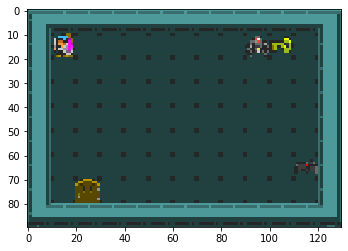

In [16]:
plt.imshow(population[9].env.env.reset())

In [ ]:
population[0].env.generator.cleanup()
for i in range(len(population)):
    population[i].env.close()